# Import Dependency  

Required 3rd party libs:  

- `numpy`
- `pandas`
- `sklearn`
- `matplotlib`, for plotting
- `pydotplus`, for plotting tree structure
- `bottleneck`, some codes mention it, but not used in this demo

All can be installed via `conda install`

In [1]:
import random
import os
import warnings
import logging
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydotplus
from sklearn.metrics import mean_squared_error
from gplearn.genetic import SymbolicRegressor, SymbolicPortfolio
from gplearn.fitness import make_fitness
from gplearn.functions import make_function
from IPython.display import clear_output, Image

from quant.loader.manager import from_in_sample

warnings.simplefilter('ignore', RuntimeWarning)
logger = logging.getLogger(__name__)
logging.basicConfig(filename='gplearn.log', encoding='utf-8', level=logging.DEBUG)

# # # # # # # # # # # # # # # # # # #
# Config this to your project path  #
# # # # # # # # # # # # # # # # # # #
dm = from_in_sample('my_project')
clear_output()

# Prepare Data  

Following data required in the demo:  

- `X`: Firm-day feature values.
  - Can either be 3-dim `ndarray`, or a `list` of `DataFrame`. 
  - If feed as `ndarray`, must has shape `(n_samples (days), n_features, n_firms)`.
  - (Recommended) Otherwise as a `list` with length `n_features`, each `DataFrame` has shape `(n_samples, n_firms)`.
  - In this demo, all `X` value are lagged for 2 days to prevent forward-looking.
- `y`: Firm-day returns.
  - Can either be `ndarray` or `DataFrame`, has shape `(n_samples, n_firms).
  - In this demo, close-to-close daily return data is chosen.
- `universe`: Firm-day valid instrument pool.
  - Can either be `ndarray` or `DataFrame`, has shape `(n_samples, n_firms).
  - `bool` array-like indicate at each day if a firm is in valid instrument pool.
  - In this demo, `valid_broad` is chosen.
- `permit_long`: Firm-day long-able instrument pool.
  - Can either be `ndarray` or `DataFrame`, has shape `(n_samples, n_firms).
  - `bool` array-like indicate at each day if a firm at this day can have higher weight than previous day.
  - Since we use close-to-close return, this is `True` if a stock did not reach upper price limit at previous day close, and has non-zero volume at that day.
  - Field `close_up_limit` is used here to indicate price limit status.
- `permit_short`: Firm-day short-able instrument pool.
  - Same as above.  

All data other than `X, y` are packed in a `dict`, with keys as above names. It is not recommended but you can have NOTHING but `X, y` (a null dict): The model can still work, although the result is expected to be inaccurate.

`X` has a total of `54` features, with first `4` being certain ratios from daily adjusted OHLC, others randomly selected from dumped level-2 fields in `dims`.  

`36` months data is taken to fit the model, later we set a `is_split=0.8` for the model so first `28` months will be used internally as in-sample, while others held as out-of-sample.

In [2]:
# # Read from parquet sample
# df = pd.read_parquet('./test_data/data.parquet')
# numeric = ['open', 'high', 'low', 'close']
# df[numeric] = df[numeric].astype(np.float64)
# df.reset_index(inplace=True)
# open_, high, low, close, permit_long, permit_short, pool = \
#     [df.pivot(index='date', columns='ticker',values=i) 
#      for i in ['open', 'high', 'low', 'close', 
#                'permit_long', 'permit_short', 'pool']]
# permit_long = permit_long.fillna(True).astype(bool)
# permit_short = permit_short.fillna(True).astype(bool)
# pool = pool.fillna(False).astype(bool)

# Read from DMGR
adj = dm['CUM_ADJ_FACTOR'].data_array.to_pandas()
open_ = dm['OPENPRICE'].data_array.to_pandas() * adj
high = dm['HIGHPRICE'].data_array.to_pandas() * adj
low = dm['LOWPRICE'].data_array.to_pandas() * adj
close = dm['CLOSEPRICE'].data_array.to_pandas() * adj
permit_long = ~dm['close_up_limit'].data_array.to_pandas()\
    .shift(1, fill_value=False)
permit_short = ~dm['close_down_limit'].data_array.to_pandas()\
    .shift(1, fill_value=False)
valid = dm['TURNOVERVOLUME'].data_array.to_pandas().shift(1, fill_value=False) > 0.
permit_long &= valid
permit_short &= valid
pool = dm['valid_broad'].data_array.to_pandas()

prev = close.shift(1)
high = (high / open_ - 1.).clip(-.2, .2)
low = (low / open_ - 1.).clip(-.2, .2)
# Close to Open (overnight)
open_ = (open_ / prev - 1.).clip(-.2, .2)
# Close to Close
close = (close / prev - 1.).clip(-.2, .2)

open_ = open_.shift(2).loc['2009-01-01':]
high = high.shift(2).loc['2009-01-01':]
low = low.shift(2).loc['2009-01-01':]
ret = close.loc['2009-01-01':]
close = close.shift(2).loc['2009-01-01':]
permit_long = permit_long.loc['2009-01-01':]
permit_short = permit_short.loc['2009-01-01':]
pool = pool.loc['2009-01-01':]

# We kept a copy of full-length data, which can be used later.
x_full = [open_, high, low, close]
y_full = ret
args_full = {
    'universe': pool,
    'permit_long': permit_long,
    'permit_short': permit_short,
}

is_start, is_end = '2020-01-01', '2022-12-31'
x_is = [i[is_start: is_end] for i in [open_, high, low, close]]
y_is = ret[is_start: is_end]
args_is = {
    'universe': pool[is_start: is_end],
    'permit_long': permit_long[is_start: is_end],
    'permit_short': permit_short[is_start: is_end],
}
clear_output()

Now load the (random) `50` fields from DMGR. If a pickle cannot be loaded by DMGR, it is skipped and another one is chosen to make sure there are enough fields at end.

In [3]:
# Plus 4 candle fields
n_features = 4 + 50

# Change this if necessary
lv2_list = list(sorted(os.listdir('/work/verify/in_sample/dim/')))

lv2_list = [i[:-4] for i in lv2_list if i.startswith('lv2') and i.endswith('.pkl')]
field_map = []
while lv2_list and n_features > 4:
    idx = random.randint(0, len(lv2_list)-1)
    field = lv2_list.pop(idx)
    try:
        temp = dm[field].data_array.to_pandas().shift(2).loc['2009-01-01':]
    except Exception:
        continue
    mask = np.isinf(temp.to_numpy())
    if mask.any():
        temp = temp.where(~mask, np.nan)
    x_full.append(temp)
    x_is.append(temp[is_start: is_end])
    field_map.append(field)
    n_features -= 1
clear_output()
field_map = {f'X{i+4}': field_map[i] for i in range(len(field_map))}
field_map.update({'X0': 'open', 'X1': 'high', 'X2': 'low', 'X3': 'close'})
print(len(field_map), '\n', field_map.values())

# You may want to dump this for later use.
with open('./field_map.pkl', 'wb') as f:
    pickle.dump(field_map, f)

54 
 dict_values(['lv2_order_ms_group_sell_skew', 'lv2_hcprc_0std', 'lv2_nearby_order_ratio', 'lv2_mf01_pas_buy_1', 'lv2_hf_cancel_q01_time', 'lv2_buy_b_sell_buy', 'lv2_active_buy_volume_runstest', 'lv2_fuzzy_corr_fz', 'lv2_byssb_1000', 'lv2_buy_order_ratio', 'lv2_vol_3s_cycle', 'lv2_hcvol_n', 'lv2_mf01_pas_sell_1', 'lv2_b_buy_b_sell_sell', 'lv2_hf_cancel_dist_skew', 'lv2_mf01_pas_buy_2', 'lv2_bid_order_split', 'lv2_bid_amt_prc10', 'lv2_all_vol_1300', 'lv2_hf_cancel_bid_num_ratio', 'lv2_active_buy_volume_ununiformity', 'lv2_bs_order_ratio_faraway', 'lv2_bysss_1000', 'lv2_bsvol_diff', 'lv2_mf01_pas_sell_2', 'lv2_num_freq_bias', 'lv2_b_buy_sell_buy', 'lv2_mf01_act_sell_1', 'lv2_alt_vwap_q9_new', 'lv2_active_buy_num_ratio', 'lv2_bybsb_1100', 'lv2_lcprc_n', 'lv2_all_vol_1000', 'lv2_blt_q9_new', 'lv2_mf01_pas_buy_3', 'lv2_lcvol_n', 'lv2_large_buy_amt_1std', 'lv2_all_vol_930', 'lv2_large_sell_amt_1std', 'lv2_last_5min_cancel_ratio', 'lv2_mf01_act_buy_2', 'lv2_hf_cancel_time_ratio', 'lv2_vol_

In [4]:
# # Uncomment this to load exact same fields used by saved model.
# with open('./field_map.pkl', 'rb') as f:
#     field_map = pickle.load(f)
# for i in field_map.values():
#     if not i.startswith('lv2'):
#         continue
#     temp = dm[i].data_array.to_pandas().shift(2).loc['2009-01-01':]
#     mask = np.isinf(temp.to_numpy())
#     if mask.any():
#         temp = temp.where(~mask, np.nan)
#     x_full.append(temp)
#     x_is.append(temp[is_start: is_end])
#     x_os.append(temp[is_end: os_end])
# clear_output()
# print(len(field_map), '\n', field_map.values())

# Customizd Functions

The user should implement customized `transformer, metrics, operators` respectively. More advanced usecase can be achieved by implementing `Callback` class.

First, customize a weight `transformer`: A `transformer` should accept 2d `weight` matrix and `dict` of arguments (like `args_is` we prepared above), and output a new 2d `weight` matrix.   

Obviously result of GP program is not guaranteeed to be tradable, this
function transform this raw weight by certain standard to make sure it is
"valid":  

 1. Make sure weights not in instrument pool (universe) are invalid;
 2. **Winsorize** left and right 2% tail to clip abnormal value;
 3. **Neutralize** the weight so long and short sum to 0;
 4. **Reweight** long and short parts so each side sum to 1 (-1);
 5. **Restrict** long position no higher than previous day if not permitted to
    buy it at previous close (reached price limit), same for short.  

There are more under the hood, check the code for detail. For what exactly is done in each imported function, refer to their docstrings.

In [5]:
# Used to regulate weight
from gplearn.fitness import winsorize, neutralize, rebalance, clip_limit
# For backtest and stats
from gplearn.fitness import df_stats


def transform_weight(weight: np.ndarray, trans_args: dict):
    '''User-made pipeline function to transform raw weights to valid ones.'''
    # If raw weight is scalar matrix (all elements are single value), make it
    # invalid, which will be handled later.
    unique = np.unique(weight)
    if len(np.unique(weight)) - int(np.nan in unique) < 2:
        return np.empty_like(weight) * np.nan
    fields = list(trans_args.keys())
    # Check instrument pool if provided.
    if 'universe' in fields:
        weight = np.where(trans_args['universe'], weight, np.nan)
    weight = winsorize(weight, 0.02, 0.98)
    weight = neutralize(weight, industry=trans_args.get('industry', None))
    weight = rebalance(weight, min_obs=1)
    if 'permit_long' in fields and 'permit_short' in fields:
        weight = clip_limit(weight, trans_args['permit_long'], 
                            trans_args['permit_short'])
    return weight  

# Finally, call this factory function to make a model-acceptable object.
transform = make_function(function=transform_weight, name='trans', arity=2)

Customize fitness `metrics`: A `metrics` should accept 2d return matrix `y`, 2d weight matrix `y_pred` and **2d** sample weight matrix `sample_weight`, then output a scalar score. 

`metrics` is required in evolution to determine which individual program is better. We use average daily IC coefficient here.

In [6]:
def ic_fitness(y: np.ndarray, y_pred: np.ndarray, sample_weight: np.ndarray):
    '''Calculate cross-sectional IC value, which is the mean of daily
    correlation between stock weight and (next-day) returns. The user should
    manually create delay0 ret for delay1 weight, or delay-1 for delay0.

    NOTE: It is tempting to take absolute value of calculated IC to keep strong
    negative correlated result, but it is usually inpractical to hold such a
    inversed portfolio. For this, real IC is returned instead of absolute and
    negative results are expected to be discarded.
    
    Parameters
    ----------
    y : array-like, shape = (n_days, n_firms)
        Daily delay0 close-to-close returns, i.e. day-t return to be BNH return
        if bought at the close price of day-t-1 and hold to day-t close.
        
    y_pred : array-like of shape (n_days, n_firms)
        Daily delay1 portfolio weight, i.e. day-t weight must can be calculated
        only using information prior to day-t-1 close.
        
    sample_weight: None or array-like of shape (n_days, n_firms)
        Daily delay0 sample weight. For IC metrics, only consider weight at
        daily level, i.e. weight will be reduced to 1d by np.nanmean()
        
    Returns
    -------
    ic_coef : float
        Sample period value of mean daily IC, which is the correlation
        coef between daily stock weights and returns.
    '''
    mask = np.isfinite(y) & np.isfinite(y_pred)
    # Penalize invalid weight.
    if mask.mean() < 0.4 or (np.abs(y_pred[mask]) < 1e-16).mean() > 0.8:
        return -1.
    y, y_pred = np.where(mask, y, 0.), np.where(mask, y_pred, 0.)
    y = np.where(mask, y - y.mean(axis=1, keepdims=True), 0.)
    y_pred = np.where(mask, y_pred - y_pred.mean(axis=1, keepdims=True), 0.)
    corr = (y * y_pred).sum(axis=1)
    corr /= np.sqrt((y*y).sum(axis=1) * (y_pred*y_pred).sum(axis=1))
    sample_weight = np.nanmean(sample_weight, axis=1)
    corr = np.nansum(corr * sample_weight) / np.nansum(sample_weight)
    return corr

# We provide sharpe as fitness as well, though not used in the demo.
def sharpe_fitness(y: np.ndarray, y_pred: np.ndarray, 
                   sample_weight: np.ndarray):
    '''Calculate sharpe ratio (without rf rate) for time-series, take
    mean along n_samples dim. The user should manually create delay0 ret
    for delay1 weight, or delay-1 for delay0.
    
    Parameters
    ----------
    y : array-like, shape = (n_days, n_firms)
        Daily delay0 close-to-close returns, i.e. day-t return to be BNH
        return if bought at the close price of day-t-1 and hold to day-t
        close.
    y_pred : array-like of shape (n_days, n_firms)
        Daily delay1 portfolio weight, i.e. day-t weight must can be
        calculated only using information prior to day-t-1 close.
    sample_weight: None or array-like of shape (n_days, n_firms)
        Daily delay0 sample weight. For sharpe metrics, only consider
        weight at daily level, i.e. weight will be reduced to 1d by
        np.nanmean()
        
    Returns
    -------
    sharpe_ratio : float
        Sharpe ratio averaged along n_samples dim.
    '''
    # A point is valid if has both finite weight and returns, otherwise
    # treat weight as 0.
    mask = np.isfinite(y) & np.isfinite(y_pred)
    # Penalize invalid weight.
    if mask.mean() < 0.2 or (np.abs(y_pred[mask]) < 1e-16).mean() > 0.9:
        return -100.
    # Turnover
    tvr = np.where(mask, y_pred, 0.)
    tvr[1:] = tvr[1:] - tvr[:-1]
    tvr = np.abs(tvr).sum(axis=1)
    # Weighted return, penalized by turnover at rate of two-sided 5e-4.
    # Then divide 2 since long and short size sum to 2.
    ret_daily = np.where(mask, y_pred * y, 0.).sum(axis=1) - 5e-4 * tvr
    ret_daily /= 2.
    # Non-compounding daily weighted returns and volatility.
    sample_weight = np.nanmean(sample_weight, axis=1)
    ret_mean = np.sum(ret_daily * sample_weight) / sample_weight.sum()
    ret_daily -= ret_mean
    ret_daily *= ret_daily
    vol = np.sum(ret_daily * sample_weight) / sample_weight.sum()
    vol = np.inf if vol < 1e-8 else np.sqrt(vol)
    return ret_mean / vol * np.sqrt(250)

metric = make_fitness(function=ic_fitness, greater_is_better=True)

Customize `operator` is achieved by applying a special wrapper to `FU class`. You can update FU as long as they still have same interface.

Each `operator` has an attribute `valid_range`, which should be a `List[int]` or `List[Tuple[int]]`: If target FU has single core param `window`, specify it as former; for multiple core params, use later (see `rzscore` below, which require seperate mean window and std window)

During evolution, an `operator` node of a program tree has its param randomly chosen from this `valid_range`, then fixed until modified by mutation.

In [7]:
from gplearn.tsfunctions import fu_factory
from vanilla_fu.fu_roll_alphabeta import calRollAlphaBeta as RAB
from vanilla_fu.fu_roll_argmax import calRollArgMax as RAMax
from vanilla_fu.fu_roll_argmin import calRollArgMin as RAMin
from vanilla_fu.fu_roll_corr import calRollCorr as RC
from vanilla_fu.fu_roll_decay_linear import calRollDecayLinear as RDL
from vanilla_fu.fu_roll_kurt import calRollKurt as RK
from vanilla_fu.fu_roll_max import calRollMax as RMax
from vanilla_fu.fu_roll_mean import calRollMean as RMean
from vanilla_fu.fu_roll_median import calRollMedian as RMedian
from vanilla_fu.fu_roll_min import calRollMin as RMin
from vanilla_fu.fu_roll_skew import calRollSkew as RSkew
from vanilla_fu.fu_roll_std import calRollStd as RStd
from vanilla_fu.fu_roll_zscore import calRollZscore as RZ

default_range = [2, 5, 10, 20, 60]
long_range = [5, 10, 20, 60]

# First arg is class, then the name of target attribute. 
# Arity is number of features required in computation
# Other kwargs passed to the class.
rbeta = fu_factory(RAB, 'res_beta', name='rbeta', arity=2, 
                   valid_range=long_range, total_ignore_nan=False, 
                   res_stats=False)
ralpha = fu_factory(RAB, 'res_alpha', name='ralpha', arity=2, 
                    valid_range=long_range, total_ignore_nan=False,  
                    res_stats=False)
riv = fu_factory(RAB, 'res_err_std', name='riv', arity=2, 
                 valid_range=long_range, total_ignore_nan=False, 
                 res_stats=True)
rargmax = fu_factory(RAMax, 'res', name='rargmax', arity=1,
                     valid_range=default_range, total_ignore_nan=False)
rargmin = fu_factory(RAMin, 'res', name='rargmin', arity=1,
                     valid_range=default_range, total_ignore_nan=False)
rcorr = fu_factory(RC, 'res', name='rcorr', arity=2, valid_range=long_range,
                   total_ignore_nan=False, flag=True)
rdecay = fu_factory(RDL, 'res', name='rdecay', arity=1, 
                    valid_range=default_range, total_ignore_nan=False)
rkurt = fu_factory(RK, 'res', name='rkurt', arity=1, valid_range=long_range,
                   total_ignore_nan=False, flag=True)
rmax = fu_factory(RMax, 'res', name='rmax', arity=1, 
                   valid_range=default_range, total_ignore_nan=False)
rmean = fu_factory(RMean, 'res', name='rmean', arity=1, 
                   valid_range=default_range, total_ignore_nan=False)
rmedian = fu_factory(RMedian, 'res', name='rmedian', arity=1, 
                     valid_range=long_range, total_ignore_nan=False)
rmin = fu_factory(RMin, 'res', name='rmin', arity=1, 
                   valid_range=default_range, total_ignore_nan=False)
rskew = fu_factory(RSkew, 'res', name='rskew', arity=1, valid_range=long_range,
                   total_ignore_nan=False, flag=True)
rstd = fu_factory(RStd, 'res', name='rstd', arity=1, valid_range=long_range,
                   total_ignore_nan=False, flag=True)
rzscore = fu_factory(RZ, 'res', name='rzscore', arity=1, 
                     valid_range=list(zip(long_range, long_range)), 
                     total_ignore_nan=False, flag=True)

`Callback` can be used to make the evolution more flexible. They are called by the model at the end of each generation. In this demo, we create `2` different `Callback`:

- `DynamicParamCallback` monitors result from latest generation, and change hyperparams if certain standard is reached;
- `SaveCallback` saves a temp model file as pickle at the end of each generation.

In [8]:
class DynamicParamCallback:
    '''Dynamically change fit params to control performance.
    This callback abuses __dict__ feature of python class, use it with
    caution.
    '''
    def __init__(self, min_fitness=None, min_variety=None, 
                 max_avg_length=None):
        assert isinstance(min_fitness, float)
        assert 0. < min_variety < 1.
        assert max_avg_length > 1
        self.min_fitness = min_fitness
        self.min_variety = min_variety
        self.max_avg_length = max_avg_length
        self.args = None

    def __call__(self, obj):
        if self.args is None:
            self.args = obj.get_params(raw=True)
        # Use aggressive params if either:
        #   1. Best fitness is lower than threshold
        #   2. Population variety is lower than threshold
        fitness = self.min_fitness is not None \
            and obj.run_details_['best_fitness'][-1] < self.min_fitness
        variety = self.min_variety is not None \
            and obj.run_details_['variety'][-1] < self.min_variety
        length = self.max_avg_length is not None \
            and obj.run_details_['average_length'][-1] > self.max_avg_length
        # No selection pressure, exploration proritized
        if fitness or variety:
            obj.__dict__.update({
                'tournament_size': 2,
                'p_crossover': 0.44,
                'p_subtree_mutation': 0.4,
                'p_hoist_mutation': 0.05,
                'p_point_mutation': 0.1,
                'p_point_replace': 0.5,
            })
        else:
            obj.__dict__.update(self.args)
        # Shrink length by stronger hoist prob.
        hoist = obj.__dict__['p_hoist_mutation']
        if length and hoist < .4:
            ratio = (.8 - hoist) / (1. - hoist)
            hoist += .2
            obj.p_hoist_mutation = hoist
            obj.p_crossover *= ratio
            obj.p_subtree_mutation *= ratio
            obj.p_point_mutation *= ratio
            

class SaveCallback:
    def __init__(self, file='./last_gen.pkl'):
        self.file = file
        
    def __call__(self, obj):
        with open(self.file, 'wb') as f:
            pickle.dump(obj, f)
        
# Another helper function to dump weight csv file for alpha loader.
def dump_csv(df, path):
    stridx = df.index.to_series().reset_index(drop=True).dt.strftime(r'%Y%m%d')
    df.reset_index(drop=True, inplace=True)
    df['date'] = stridx
    df = df.drop_duplicates(subset=['date']).reset_index(drop=True)
    df.to_csv(path, sep='|', index=None)
    return df

# Building Block: `_Program` Class  

Before diving to the model, we should check some basic class used during evolution. `_Program` is the building block, which represents a tree of nodes that can be execute (predict values) given inputs `X`. Refer to its docstring for argument definitions.  

We generate a random `_Program` here, and see how it works:

div(rcorr(60, rbeta(10, X10, abs(X23)), abs(rdecay(5, X20))), rargmin(60, add(rzscore((10, 10), X15), X46)))


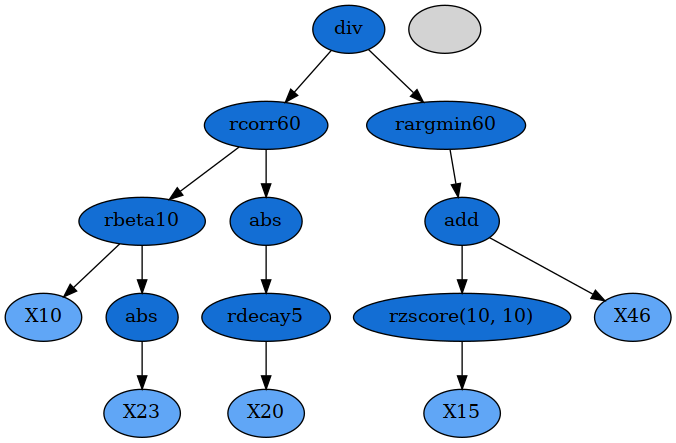

In [9]:
from gplearn.functions import _function_map
from gplearn._program import _Program
from gplearn.utils import _check_input

# Set of functions that can be used when building the tree.
function_set = [_function_map[i] for i in ['add', 'sub', 'mul', 'div', 'abs', 'sqrt']]
function_set.extend([rbeta, ralpha, rargmax, rargmin, rcorr, rdecay, 
                     rmean, rstd, rzscore])

# Some internal attributes required to generate random tree. Can ignore this.
arities = {}
for function in function_set:
    arity = function.arity
    arities[arity] = arities.get(arity, [])
    arities[arity].append(function)

# Prepare some data to check the program works.
X, y, sample_weight, trans_args, _, _ = \
    _check_input(x_is, y_is, None, args_is)
    
n_features = X.shape[1]
# Create a program (not required in real usecase)
# Leaving ``program=None`` means generate a random tree.
# Refer the docstring for other arguments.
program = _Program(
    function_set=function_set,
    arities=arities,
    init_depth=(2, 4),
    init_method='grow',
    n_features=n_features,
    const_range=(-1., 1.),
    metric=metric,
    p_point_replace=0.1,
    p_grow_terminal=0.33,  # Chance of choosing terminal over func on any node.
    parsimony_coefficient=1e-2,
    random_state=np.random.RandomState(42),
    transformer=transform,
    program=None,
)

# Call str or print to print formula, use pydotplus to visualize in graph.
print(program)
graph = program.export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

`_Program` is designed to work under the hood, most of its method only accept internally-cooked ndarray data, except `execute()`, which can be called with the data pack we prepared to generate stock weight predictions. Refer to its docstring for argument definitions.

In [10]:
y_pred = program.execute(x_is, args_is, transform=True)
y_pred.tail()

ticker,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,873527.BJ,000016.SH,000300.SH,000852.SH,000905.SH,000985.CSI,H00016.CSI,H00300.CSI,H00852.CSI,H00905.CSI
date,,,,,,,,,,,,,,,,,,,,,
2022-12-26,-0.000455,-0.000253,NaN,NaN,-0.000217,0.001242,-0.000352,0.000903,0.000034,-0.000152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,-0.000413,-0.000204,NaN,NaN,-0.000189,0.001190,-0.000355,0.000834,0.000038,-0.000135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,-0.000333,-0.000139,NaN,NaN,-0.000189,0.001037,-0.000127,0.000681,0.000037,-0.000110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,-0.000566,-0.000170,NaN,NaN,-0.000285,0.002092,-0.000240,0.001137,0.000063,-0.000190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,-0.000545,-0.000100,NaN,NaN,-0.000285,0.002172,-0.000234,0.000858,0.000068,-0.000181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Create and Fit a Model  

Now we can create a `SymbolicRegressor` model and fit it with our data pack. 

Note that we set `is_split=0.8`, which means fitness is only evaluated on first `80%` sample days. During the evolution, OS fitness is also calculated for best programs and reported. You can access any evaluated program's fitness with attribute name `raw_fitness_, os_fitness_`.

Refer to the docstring for argument definition.  

For demonstration purpose, we choose small `generations` and `population_size`. So the result may not be ideal. You can experiment with other hyper params.

In [11]:
os.environ['PYTHONWARNINGS'] = 'ignore'

kwargs = {
    'generations': 5,
    'metric': metric,
    'transformer': transform,
    'stopping_criteria': 100.,
    'population_size': 500,
    'tournament_size': 10,
    'init_depth': (3, 5),
    'parsimony_coefficient': 1e-4,
    'p_grow_terminal': 0.33,
    'p_crossover': 0.85,
    'p_subtree_mutation': 0.05,
    'p_hoist_mutation': 0.02,
    'p_point_mutation': 0.05,
    'p_point_replace': 0.2,
    'is_split': 0.8,
    'elitism': 50,
    'variety': 'corr',
    'verbose': 1,
    'n_jobs': 64,
    'function_set': ['add', 'sub', 'mul', 'div', 'abs', 'neg', 'inv', rbeta, 
                     ralpha, rargmax, rargmin, rcorr, rdecay, rmax, 
                     rmean, rmin, rstd, rzscore],
    'callbacks': [DynamicParamCallback(min_fitness=0.005, min_variety=0.4, 
                                       max_avg_length=30), 
                  SaveCallback()],
    # 'warm_start': True,
    # 'const_range': None,
}

reg = SymbolicRegressor(**kwargs)
reg.fit(x_is, y_is, sample_weight=None, trans_args=args_is)

# reg.load('/home/thchu/model/gplearn/ts_l2_01.pkl')

    |    Population Average    |     Best Individual      |
---- -------------------------- -------------------------- ----------
 Gen   Length  Variety  Fitness   Length  Fitness OS Fitness  Time Left
loading config file:/home/thchu/.local/lib/python3.8/site-packages/xy/config.ini@2024-07-30 15:58:59.113488
logging configured successfully with root logger<RootLogger root (INFO)>
loading config file:/home/thchu/.local/lib/python3.8/site-packages/xy/config.ini@2024-07-30 15:58:59.226676
logging configured successfully with root logger<RootLogger root (INFO)>
loading config file:/home/thchu/.local/lib/python3.8/site-packages/xy/config.ini@2024-07-30 15:58:59.257976
logging configured successfully with root logger<RootLogger root (INFO)>
loading config file:/home/thchu/.local/lib/python3.8/site-packages/xy/config.ini@2024-07-30 15:58:59.272319
loading config file:/home/thchu/.local/lib/python3.8/site-packages/xy/config.ini@2024-07-30 15:58:59.273616
logging configured successfully with ro

SymbolicRegressor(_metric=<gplearn.fitness._Fitness object at 0x7fcf62df59d0>,
                  _transformer=<gplearn.functions._Function object at 0x7fd15845bd00>,
                  arities={1: [<gplearn.functions._Function object at 0x7fcfe1b67ee0>,
                               <gplearn.functions._Function object at 0x7fcfe1b679d0>,
                               <gplearn.functions._Function object at 0x7fcfe1b67e80>,
                               <gplearn.functions._TSFunction object at 0x7f...
                  metric=<gplearn.fitness._Fitness object at 0x7fcf62df59d0>,
                  n_jobs=64, p_crossover=0.44, p_grow_terminal=0.33,
                  p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_point_replace=0.5, p_subtree_mutation=0.4,
                  parsimony_coefficient=0.0001, population_size=500,
                  stopping_criteria=100.0, tournament_size=2,
                  transformer=<gplearn.functions._Function object at 0x7fd15845bd00>,
                  verbose=1)

A fitted model can `predict` with its best single program. Setting `transform=True` calls its transformer to produce "valid" weight.

In [12]:
pred = reg.predict(x_is, args_is, transform=True)
pred.tail()

ticker,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,873527.BJ,000016.SH,000300.SH,000852.SH,000905.SH,000985.CSI,H00016.CSI,H00300.CSI,H00852.CSI,H00905.CSI
date,,,,,,,,,,,,,,,,,,,,,
2022-12-26,0.000595,-0.000266,NaN,NaN,-0.001439,0.000598,-0.000242,0.000100,0.000251,0.000503,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,-0.000036,-0.000024,NaN,NaN,-0.001254,0.000496,-0.000345,-0.000121,0.000270,0.000435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,-0.000175,-0.000010,NaN,NaN,-0.001262,0.000354,-0.000206,-0.000482,-0.000069,0.000521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,0.000511,0.000264,NaN,NaN,-0.001392,0.000516,-0.000056,-0.000431,-0.000057,0.000275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,0.000047,0.000116,NaN,NaN,-0.001195,0.000359,-0.000051,-0.000093,-0.000081,0.000284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can `save` / `load` models.

In [13]:
reg.save('./test_run.pkl')

# Create a blank model and load pickle.
reg_new = SymbolicRegressor()
reg_new.load('./test_run.pkl')
pred_new = reg_new.predict(x_is, args_is, transform=True)
pred_new.tail()

ticker,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,873527.BJ,000016.SH,000300.SH,000852.SH,000905.SH,000985.CSI,H00016.CSI,H00300.CSI,H00852.CSI,H00905.CSI
date,,,,,,,,,,,,,,,,,,,,,
2022-12-26,0.000595,-0.000266,NaN,NaN,-0.001439,0.000598,-0.000242,0.000100,0.000251,0.000503,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,-0.000036,-0.000024,NaN,NaN,-0.001254,0.000496,-0.000345,-0.000121,0.000270,0.000435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,-0.000175,-0.000010,NaN,NaN,-0.001262,0.000354,-0.000206,-0.000482,-0.000069,0.000521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,0.000511,0.000264,NaN,NaN,-0.001392,0.000516,-0.000056,-0.000431,-0.000057,0.000275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,0.000047,0.000116,NaN,NaN,-0.001195,0.000359,-0.000051,-0.000093,-0.000081,0.000284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


One will naturally want more than one program. All programs during the evolution will be stored at `_programs` attribute, which is a hierachical list with first index being generation, then program No.

Note that for other than last generation, if a program has not reproduced any child, it will be released from memory (replaced with `None`).

In [14]:
# Take last generation, sort by fitness (the higher the better)
population = reg._programs[-1]
fn = lambda x: x.raw_fitness_
population = list(sorted(population, key=fn, reverse=True))

# Take second-best program
program = population[1]
print(program)
print(f'IS fitness: {program.raw_fitness_:.5f}, '
      f'OS fitness: {program.os_fitness_:.5f}')
pred_sec = program.execute(x_is, args_is, transform=True)
pred_sec.tail()

add(X23, rdecay(2, X20))
IS fitness: 0.03441, OS fitness: 0.02981


ticker,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,873527.BJ,000016.SH,000300.SH,000852.SH,000905.SH,000985.CSI,H00016.CSI,H00300.CSI,H00852.CSI,H00905.CSI
date,,,,,,,,,,,,,,,,,,,,,
2022-12-26,0.000449,-0.000247,NaN,NaN,-0.001444,0.000544,-0.000270,0.000080,0.000321,0.000582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,-0.000025,-0.000012,NaN,NaN,-0.001263,0.000453,-0.000327,-0.000107,0.000195,0.000509,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,-0.000168,0.000057,NaN,NaN,-0.001263,0.000390,-0.000289,-0.000491,-0.000038,0.000570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,0.000377,0.000242,NaN,NaN,-0.001395,0.000565,-0.000037,-0.000413,-0.000030,0.000329,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,0.000056,0.000160,NaN,NaN,-0.001200,0.000415,-0.000090,-0.000126,-0.000085,0.000332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


If you want, you can create a portfolio from some best programs in the last generation. This will return an unfitted `SymbolicPortfolio` class, then call its `fit` method to generate weight for each program.

Refer to docstring for argument definitions.

In [15]:
port = reg.make_portfolio(min_programs=5, max_programs=None, 
                          fitness_threshold=0.01, corr_threshold=0.8, 
                          is_split=0.8, use_raw_fitness=True)
port.fit()
port

SymbolicPortfolio(method=sharpe, fitted=True, n_programs=23)

Fitted `SymbolicPortfolio` has `predict` method as well. And it runs in parallel since there could be a large number of programs.

In [16]:
pred_port = port.predict(x_is, args_is)
pred_port.tail()

loading config file:/home/thchu/.local/lib/python3.8/site-packages/xy/config.ini@2024-07-30 16:03:26.216922
logging configured successfully with root logger<RootLogger root (INFO)>
loading config file:/home/thchu/.local/lib/python3.8/site-packages/xy/config.ini@2024-07-30 16:03:26.220971
loading config file:/home/thchu/.local/lib/python3.8/site-packages/xy/config.ini@2024-07-30 16:03:26.221402
logging configured successfully with root logger<RootLogger root (INFO)>
logging configured successfully with root logger<RootLogger root (INFO)>
loading config file:/home/thchu/.local/lib/python3.8/site-packages/xy/config.ini@2024-07-30 16:03:26.230024
logging configured successfully with root logger<RootLogger root (INFO)>
loading config file:/home/thchu/.local/lib/python3.8/site-packages/xy/config.ini@2024-07-30 16:03:26.257190
logging configured successfully with root logger<RootLogger root (INFO)>
loading config file:/home/thchu/.local/lib/python3.8/site-packages/xy/config.ini@2024-07-30 16:

ticker,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,873527.BJ,000016.SH,000300.SH,000852.SH,000905.SH,000985.CSI,H00016.CSI,H00300.CSI,H00852.CSI,H00905.CSI
date,,,,,,,,,,,,,,,,,,,,,
2022-12-26,0.000811,-0.000172,NaN,NaN,-0.001294,0.000716,-0.000039,0.000133,-0.000309,-0.000284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,-0.000058,0.000126,NaN,NaN,-0.000898,0.000260,-0.000348,-0.000035,0.000239,-0.000265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,0.000042,-0.000212,NaN,NaN,-0.001157,0.000104,0.000111,0.000082,-0.000156,0.000052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,0.000867,0.000659,NaN,NaN,-0.001211,0.000106,-0.000182,-0.000190,-0.000224,-0.000060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,0.000119,-0.000004,NaN,NaN,-0.000872,-0.000115,-0.000200,0.000294,-0.000074,-0.000019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`SymbolicPortfolio` also has `save` and `load` method.

In [17]:
port.save('./test_run_port.pkl')

port_new = SymbolicPortfolio()
port_new.load('./test_run_port.pkl')
port_new.predict(x_is, args_is).tail()

ticker,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,873527.BJ,000016.SH,000300.SH,000852.SH,000905.SH,000985.CSI,H00016.CSI,H00300.CSI,H00852.CSI,H00905.CSI
date,,,,,,,,,,,,,,,,,,,,,
2022-12-26,0.000811,-0.000172,NaN,NaN,-0.001294,0.000716,-0.000039,0.000133,-0.000309,-0.000284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,-0.000058,0.000126,NaN,NaN,-0.000898,0.000260,-0.000348,-0.000035,0.000239,-0.000265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,0.000042,-0.000212,NaN,NaN,-0.001157,0.000104,0.000111,0.000082,-0.000156,0.000052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,0.000867,0.000659,NaN,NaN,-0.001211,0.000106,-0.000182,-0.000190,-0.000224,-0.000060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,0.000119,-0.000004,NaN,NaN,-0.000872,-0.000115,-0.000200,0.000294,-0.000074,-0.000019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Evaluate the Result  

We provide a interactive function for `DataFrame` weight matrix. You can roughly check performance with it first.

Refer to its docstring for how could it be used.

In [18]:
stats, pnl = df_stats(y_is, pred)
stats

,days,ic,ret,sharpe,ret_long,sharpe_long,long_size,short_size,min_coverage,coverage,maxwt,avg_maxwt,max_tvr,avg_tvr,max_dd
2020,241.0,0.037000,0.220734,5.602152,0.337408,1.303137,0.997561,-1.003016,0.898937,0.920577,0.001719,0.001557,1.987817,1.078354,-0.018989
2021,243.0,0.032538,0.207861,6.376889,0.358902,2.024912,0.997140,-1.003178,0.904806,0.920222,0.001827,0.001563,1.414497,1.134716,-0.013540
2022,242.0,0.032008,0.194422,6.441965,0.001080,0.004240,0.997848,-1.001963,0.914606,0.923902,0.001668,0.001495,1.324334,1.070996,-0.009926
ALL,726.0,0.033843,0.207655,6.066103,0.232493,0.997333,0.997516,-1.002720,0.898937,0.921567,0.001827,0.001538,1.987817,1.094766,-0.018989


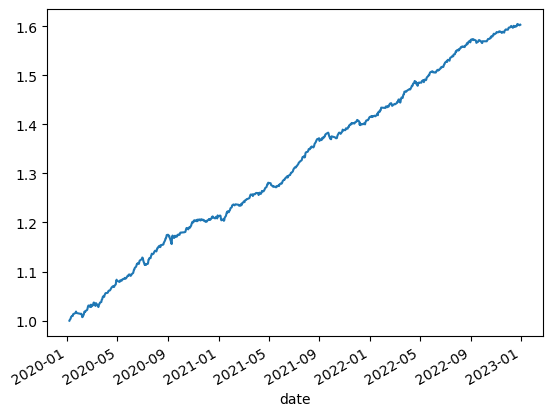

In [19]:
pnl.plot()
plt.show()

Alternatively, use the csv dump helper to dump a csv file that can be read by alphaloader.

In [20]:
dump_start = '2010-01-01'
pred_full = reg.predict(x_full, args_full, transform=True)
temp = pred_full.loc[dump_start:]
dump_csv(temp, './weight_dump.csv')

ticker,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,000016.SH,000300.SH,000852.SH,000905.SH,000985.CSI,H00016.CSI,H00300.CSI,H00852.CSI,H00905.CSI,date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20100104
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20100105
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20100106
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20100107
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20100108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155,-0.000036,-0.000024,NaN,NaN,-0.001254,0.000496,-0.000345,-0.000121,0.000270,0.000435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20221227
3156,-0.000175,-0.000010,NaN,NaN,-0.001262,0.000354,-0.000206,-0.000482,-0.000069,0.000521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20221228
3157,0.000511,0.000264,NaN,NaN,-0.001392,0.000516,-0.000056,-0.000431,-0.000057,0.000275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20221229
3158,0.000047,0.000116,NaN,NaN,-0.001195,0.000359,-0.000051,-0.000093,-0.000081,0.000284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20221230
